# Importing useful packages and libraries

In [0]:
import numpy as np
import pdb
import matplotlib.pyplot as plt
import pandas  as pd
from sklearn.preprocessing import  scale
import seaborn as sns
import cv2

colab = True

In [0]:
if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    root_path = 'gdrive/My Drive/Colab Notebooks/prime_project/data/'
else:
    root_path = '../The BeeImage Dataset from Kaggle/'
    
directory =  root_path+"/bee_imgs/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Perliminary EDA

We the read the *.csv* file containing metadata about The BeeImage Dataset.

In [0]:
df = pd.read_csv(root_path+"bee_data.csv")
n_tot = df['file'].count()
print("Total images in the dataset: {}".format(n_tot))
df.head()

Total images in the dataset: 5172


,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


For the purposes of the current work, we are only interested in associating each bee to the proper subspecies. For this reason, we are going to discard the images repsenting bees whose subspecies is unknown.

Images left: 4744
Images lost: 8.275328692962105%
Distinct values of subspecies = 6



Text(0.5, 0, 'Frequency')

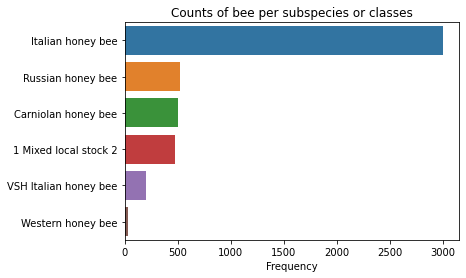

In [0]:
df = df[df['subspecies'] != '-1'] # remove images for which we do not have the class label
print("Images left: {}\nImages lost: {}%".format(df['file'].count(), 100-df['file'].count()/n_tot*100))
print("Distinct values of subspecies = {}\n".format(df["subspecies"].nunique()))
# print("Counting the distinct values of subspecies:\n{}".format(df["subspecies"].value_counts()))

subspecies_counts = df["subspecies"].value_counts()
plt.title("Counts of bee per subspecies or classes")
g = sns.barplot(x = subspecies_counts, y = subspecies_counts.index)
g.set_xlabel("Frequency")

# Loading images and pre-processing

In [0]:
def load_images(directory, files):
    '''Load images from disk'''
    X = []
    for img_name in files:
        img = cv2.imread(directory + img_name, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        img = np.array(img)
        X.append(img)
    X = np.array(X)
    return X

def show_image_shapes(images,n):
    '''Print the shape of n images randomly chosen'''
    for i in range(n):
        r = np.random.randint(low=0, high=len(images))
        print("image number {} has shape = {}".format(r, images[r].shape))

def show_image(image, ax = plt, title = None, show_size = False):
    '''Plots a given np.array image'''
    ax.imshow(image)
    if title:
        if ax == plt:
            plt.title(title)
        else:
            ax.set_title(title)
    if not show_size:
        ax.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)
        
def show_images(images, titles = None, show_size = False):
    '''Plots many images from the given list of np.array images'''
    cols = 4
    f, ax = plt.subplots(nrows=int(np.ceil(len(images)/cols)),ncols=cols, figsize=(14,5))
    ax = ax.flatten()
    for i, image in enumerate(images):
        if titles:
            show_image(image, ax = ax[i], title = titles[i], show_size = show_size)
        else:
            show_image(image, ax = ax[i], title = None, show_size = show_size)
    plt.show()       

Firstly we load the images.

In [0]:
images = load_images(directory, df.file.values)

Then we display some images and their shape.

In [0]:
show_image_shapes(images,5)

image number 2420 has shape = (36, 57, 3)
image number 3230 has shape = (64, 231, 3)
image number 2600 has shape = (54, 41, 3)
image number 699 has shape = (40, 63, 3)
image number 4732 has shape = (52, 57, 3)


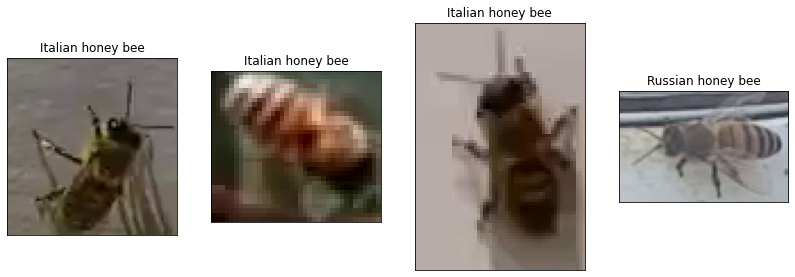

In [0]:
show_images(images[::1200],list(df["subspecies"][::1200]))

As we can see from the previous outputs, images basically have different shapes. However, in order to train our CNN, all input images should have the same shape. Therefore, we need to reshape them somehow. Basically we have the following possibilities:

 * reshape all images to **the smallest image size**: applying this technique will lead to huge loss in data quality, which is not acceptable in our case since images already have a very low quality;

 * reshape all images to **the highest image size**: this technique may lead to noisy images and the network may not learn anything at all.


Here we propose an approch who finds **the most frequent image shape** and use to reshape the other images. The intuition behind this technique is that it may allow to reshape only few images therefore, preserving data quality for most of our images.

Furthermore, the original aspect ratio may not fit into the one forced by the new shape. Eventually, reshaping can be carried out in two different ways:

 * by **shrinking and stretching** the original image up to the requested shape;

 * by **preserving the original aspect ratio** by adding black pixels as padding.

In the following we will implement both techniques to test which is the best one.


## Finding the most frequent image shape

In [0]:
def get_images_wh(images):
    '''Returns a tuple of lists, representing the widths and heights of the given images, respectively.'''
    widths = []
    heights = []
    for image in images:
        h, w, rbg = image.shape
        widths.append(w)
        heights.append(h)
    return (widths, heights)

def get_best_average(dist, cutoff = .5):
    '''Returns an integer of the average from the given distribution above the cutoff.
    '''
    # requires single peak normal-like distribution
    hist, bin_edges = np.histogram(dist, bins = 25);
    total_hist = sum(hist)
    
    # associating proportion of hist with bin_edges
    hist_edges = [(vals[0]/total_hist,vals[1]) for vals in zip(hist, bin_edges)]
    
    # sorting by proportions (assumes normal-like dist such that high freq. bins are close together)
    hist_edges.sort(key = lambda x: x[0])
    lefts = []
    
    # add highest freq. bins to list up to cutoff % of total
    while cutoff > 0:
        vals = hist_edges.pop()
        cutoff -= vals[0]
        lefts.append(vals[1])
        
    # determining leftmost and rightmost range, then returning average
    diff = np.abs(np.diff(lefts)[0]) # same diff b/c of bins
    leftmost = min(lefts)
    rightmost = max(lefts) + diff
    return int(np.round(np.mean([rightmost,leftmost])))

In [0]:
wh = get_images_wh(images)

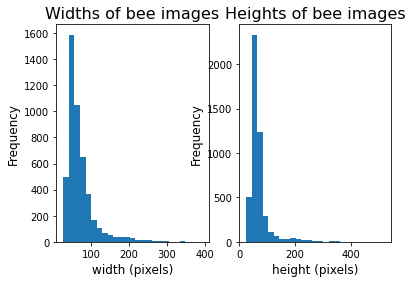

In [0]:
size = 12
plt.subplot(1,2,1)
plt.title("Widths of bee images", fontsize = size * 4/3, pad = size/2)
plt.ylabel("Frequency", size = size)
plt.xlabel("width (pixels)", size = size)
plt.hist(wh[0], bins = 25);

plt.subplot(1,2,2)
plt.title("Heights of bee images", fontsize = size * 4/3, pad = size/2)
plt.ylabel("Frequency", size = size)
plt.xlabel("height (pixels)", size = size)
plt.hist(wh[1], bins = 25);

We can notice that the distribution of **width** and **height** of images is very biased towards small values. So we will consider only the $50 \%$ most frequent values for **weigth** and **height**, then we will average them to determine the shape of our input images. This technique will allow to alter the least majority of the data.

*NOTE*: we could have defined **width** and **height** as the average over the width and shape of all the images. However, this technique should have not been efficient since the distrinution of the two variables is mainly concentrated around the interval $[48, 78]$.

In [0]:
ideal_width, ideal_height = get_best_average(wh[0]), get_best_average(wh[1])
print("the ideal height and width for our images are ",ideal_height,ideal_width) 

the ideal height and width for our images are  64 56


## Resizing the images

In order to resize our images, we can use the package *opencv* which already implement some useful functions to resize an image. 

In [0]:
def resize_images_stretching(images,new_shape):
    """
    resize the entire data set of images
        @input
            - images: ndarray of shape=(n_images,) where each image if of shape (height,width,n_channel)
            - new_shape : a tuple (height,width)
        @returns:
            an ndarray representing the reshaped image dataset
    """
    size = (new_shape[1], new_shape[0]) # because dsize should be (width,height)
    reshaped_images = []
    for image in images:
        image = cv2.resize(src=image, dsize= size, interpolation = cv2.INTER_AREA)
        reshaped_images.append(image)  
    return np.asarray(reshaped_images)

def resize_images_padding(images, desired_size=64):
    """
    resize the entire data set of images with black padding
    in order to the aspect ratio
        @input
            - images: ndarray of shape=(n_images,) where each image if of shape (height,width,n_channel)
            - desired_size : an int
        @returns:
            an ndarray representing the reshaped image dataset
    """
    reshaped_images = []
    color = [0, 0, 0]

    for img in images:
        old_size = img.shape[:2]
        ratio = float(desired_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])

        img = cv2.resize(img, (new_size[1], new_size[0]))

        delta_w = desired_size - new_size[1]
        delta_h = desired_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        
        new_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
        reshaped_images.append(new_img)

    return np.asarray(reshaped_images)

def dataset_statistics(images):
    print("The total number of images is :",len(images))
    s = images[0].shape
    uniform = True
    for i in images:
        if i.shape != s:
            uniform = False
    if uniform:
        print("All images have the same shape which is ",s)
    else:
        print("WARNING: all images does not have the same shape,therefore it's not possible to train a CNN")     

In [0]:
black_padding = True
if black_padding:
  new_shape = (ideal_height,ideal_height, 3)
  reshaped_images = resize_images_padding(images,ideal_height)
else:
  new_shape = (ideal_height,ideal_width, 3)
  reshaped_images = resize_images_stretching(images,new_shape)

The total number of images is : 4744
All images have the same shape which is  (64, 64, 3)


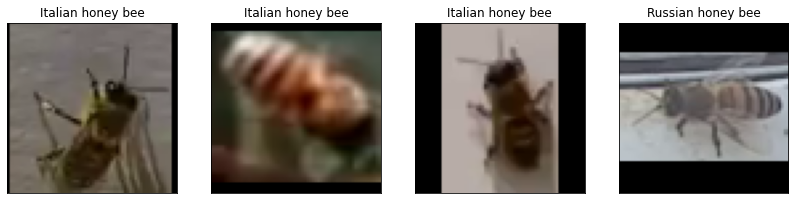

In [0]:
dataset_statistics(reshaped_images)
show_images(reshaped_images[::1200],list(df["subspecies"][::1200]))

We define a function to normalize the images in the interval $[0, 1]$. This might improve the accuracy.

In [0]:
def normalize_images(X):
    """
    function that allows to normalize pixels of the image between [0,1]

    @input
        - X : ndarray of shape=(n_images,heigth,width,n_channels)
    @returns
        - X : normalized dataset with the same shape
    """
    n_images,heigth,width,nb_channels = X.shape[0],X.shape[1],X.shape[2],X.shape[3]
    #Reshape the data-set in order to have 2-D array. it will trasform X from (n_images,h,w,channels) to --> (n_images,h*w*n_channels)
    X = np.reshape(X,newshape=(n_images,-1))
    X = scale(X)
    X = np.reshape(X,newshape=(n_images,heigth,width,nb_channels))
    return X

We also need to encode the labels with integer values.

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

le = LabelEncoder()
y = le.fit_transform(df.subspecies.values)
y = to_categorical(y)
# lablels_dictionaty = le.get_params() # get the dictionay of mapping between classes and indexes

Now we can finally split the data for training and testing purposes.

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(reshaped_images, y, test_size=0.2, random_state=2020)

In [0]:
print("X_train.shape = {}\nX_test.shape = {}\ny_train.shape = {}\ny_test.shape ={}"
      .format(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape))

X_train.shape = (3795, 64, 64, 3)
X_test.shape = (949, 64, 64, 3)
y_train.shape = (3795, 6)
y_test.shape =(949, 6)


# Building the CNN with Keras

In [0]:
import tensorflow as tf

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
print(keras.__version__)

2.2.5


In the following we will use image generators in order to load data. Data generators are on-the-fly image transformers and are the recommended way of providing image data to models in Keras. They let you work with on-disk image data too large to fit all at once in-memory. They allow also to preprocess the images the model sees with random image transformations and standardizations, a key technique for improving model performance. For more see https://keras.io/preprocessing/image/.

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)
train_datagen.fit(X_train)
test_datagen.fit(X_test)

In [0]:
img_rows, img_cols, nb_channels = new_shape
if black_padding:
  input_shape = ()
input_shape = (img_rows, img_cols, nb_channels)
nb_classes = Y_train.shape[1]

nb_filters = 32
kernel_size = (3, 3)
pool_size = (2, 2)

model = Sequential()
model.add(Conv2D(
    filters = nb_filters, 
    kernel_size = kernel_size, 
    activation='relu',
    padding= "same",
    kernel_initializer = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None), 
    input_shape = input_shape,
    name = "conv_1"
))
model.add(Conv2D(
    filters = nb_filters,
    kernel_size = kernel_size,
    activation='relu',
    padding ="same",
    kernel_initializer = "random_uniform",
    name='conv_2'
))
model.add(MaxPooling2D((2, 2), name="max_pool_2"))
model.add(Conv2D(
    filters = nb_filters,
    kernel_size = kernel_size,
    activation='relu',
    padding ="same",
    kernel_initializer= "random_uniform",
    name='conv_3'
))
model.add(MaxPooling2D((2, 2), padding="same", name = "max_pool_3"))
model.add(Flatten())
model.add(Dense(
    nb_classes,
    activation='softmax',
    kernel_initializer="random_uniform",
    name='dense'
))

Now we compile the model, define the loss and the optimizer.

In [0]:
learning_rate = 0.01

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=learning_rate),
              metrics=['accuracy'])

Finally we define a function to plot the accuracy and the loss over epochs during training.

In [0]:
def plot_acc_loss(acc,loss):
    """
    plot the accuracy and the loss over epchos
        @input:
            - acc : array of shape=(n_epochs,) representing the accuracy of the model during training over epochs
            - loss: array of shape=(n_epochs,) representing the loss of the model during training
    """
    plt.plot(acc,"g",label="accuracy")
    plt.plot(loss,"r",label="loss")
    plt.xlabel("epoch")
    plt.ylabel("metric")
    plt.legend()
    plt.show()

We get the summary of the model so that we can have an idea of the architechture and the weigths that will be trained.

In [0]:
'''
the number of trainable of parameters at each layers is equal to
the total number of weight of all the filters at each layer;
in this case 3*3*(size of each filter) *
    3*(depth of each filter) *
    32*(total number of filters at the first layer) +
    32(each filter has a bias) = 896
'''
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pool_3 (MaxPooling2D)    (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                

Finally we train the model.

In [0]:
n_epochs = 5
batch_size = 64

history = model.fit_generator(
    train_datagen.flow(x= X_train, y = Y_train, batch_size=batch_size, shuffle=True),
    steps_per_epoch=len(X_train),
    epochs=n_epochs,
    verbose = 1
)
# model.fit(X_train, Y_train_kereas,
#            batch_size=batch_size, 
#           epochs=n_epochs,
#           verbose=1, 
#           validation_data=(X_test, Y_test_kereas))

Epoch 1/5
3795/3795 [==============================] - 259s 68ms/step - loss: 0.5509 - acc: 0.7998
Epoch 2/5
3795/3795 [==============================] - 260s 68ms/step - loss: 0.2448 - acc: 0.8972
Epoch 3/5
3795/3795 [==============================] - 263s 69ms/step - loss: 0.2238 - acc: 0.9165
Epoch 4/5
3795/3795 [==============================] - 263s 69ms/step - loss: 0.1726 - acc: 0.9293
Epoch 5/5
3795/3795 [==============================] - 260s 69ms/step - loss: 0.1406 - acc: 0.9409


We can now evaluate the performances of the model on test data.

In [0]:
score = model.evaluate(X_test, Y_test, verbose=True)
print('Test score:', score[0])
print('Test accuracy:', score[1])

949/949 [==============================] - 0s 229us/step
Test score: 6.148320923615306
Test accuracy: 0.618545838100767


In the end, we plot accuracy and the loss over epochs during training.

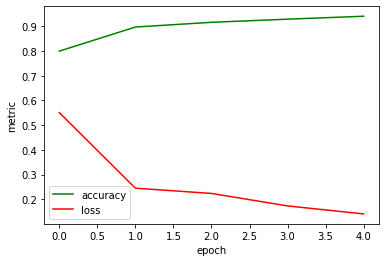

In [0]:
loss = history.history["loss"]
acc = history.history["acc"]
plot_acc_loss(acc,loss)    

Plotting the confusion matrix  might be useful in order to evaluate the overall performance of the network.

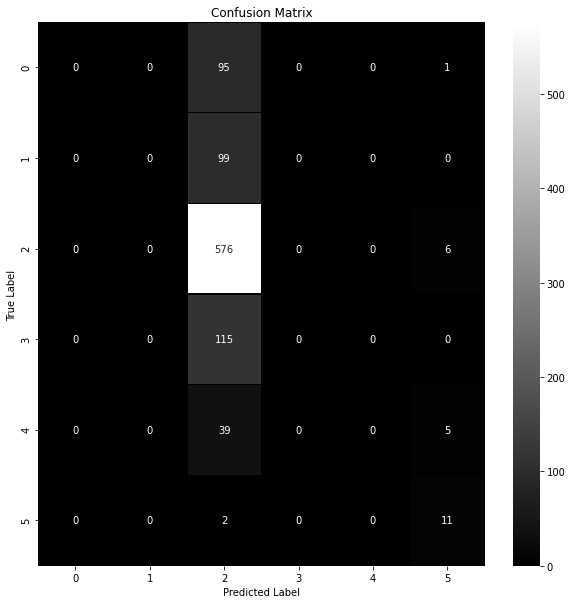

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_test, axis = 1)
confusionMatrix = confusion_matrix(Y_true, Y_pred_classes)
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(confusionMatrix, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

As first interpretation, we can notice that the bias we had in input is replicated in output because the model learns very well how to predict **italian honey bee** since it's the dominant class in the dataset. Moreover, the classifer tends to classify rare classes as belonging to **italian honey bee class** as we can see from column 2 of the confusion matrix.

# Apply ZCA preprocessing technique to improve the accuracy